In [1]:
import numpy as np
import pandas as pd 
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, roc_auc_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold, learning_curve
from sklearn.model_selection import learning_curve
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import optuna

!python -m spacy download el_core_news_sm
import spacy

!pip install greek-stemmer-pos
from greek_stemmer import stemmer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 55.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_sm')
  Obtaining dependency information for pytest-cov from https://files.pythonhosted.org/packages/a7/4b/8b78d126e275efa2379b1c2e09dc52cf70df16fc3b90613ef82531499d73/pytest_cov-4.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for coverage[toml]>=5.2.1 from https://files.pythonhosted.org/packages/b3/91/1f1c7f3351e4c996558e67bfe4f04084b7d01878e2bb55640652e1ee908f/coverage-7.4.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 2.4 MB/s eta 0:00:00
/kaggle/input/ys19-2023-assignment-2/sample_submission.csv
/kaggle/input/ys19-2023-assignment-2/test_set.csv
/kag

In [2]:
df = pd.read_csv("../input/ys19-2023-assignment-2/train_set.csv")
df_valid_csv = pd.read_csv("../input/ys19-2023-assignment-2/valid_set.csv")
df_test_csv = pd.read_csv("../input/ys19-2023-assignment-2/test_set.csv")

nlp = spacy.load("el_core_news_sm")
line_vectors = []
special_characters = "!@#$%^&*()-_+[]{}|;:'\"<>,.?/~`«»"
extra_stopwords = ['ότι', 'για', 'θα', 'την', 'του', 'να', 'στο', 'στου', 'στον', 'στην', 'στη', 'στα', 'και', 'οτι', 'ένα', 'ενα', 'δύο', 'δυο', 'ε', 'σε', 
                   'σου', 'πιο', 'όπως', 'οπως', 'άλλος', 'ως', 'ας', 'έτσι', 'αυτός', 'ένας', 'γιατί', 'γιατι', 'μου', 'κλπ', 'επί', 'όταν', 'είμαι', 
                   'ειμαι', 'είναι', ' ', '  ', '   ', '    ', 'έχω', 'εχω', 'ενώ', 'εγώ', 'τώρα', 'εγω', 'ή', 'σαν', 'σε ο', 'από', 'όπως', 'από', 'απο',
                   'όλοι', 'ολοι', 'όλα', 'ολα']

# Remove URLs, mentions, special characters and lowercasing
def clean_tweet(line):
    line = re.sub(r'http\S+', '', line)
    line = re.sub(r'@[A-Za-z0-9]+', '', line) 
    line = line.lower()
    for char in special_characters:
        line = line.replace(char, ' ')
    return line

# Tokenization and stemming
def clean_word_vector(line):
    filtered_vector = []
    text = nlp(line)
    for token in text:
        token = token.lemma_
        if ' ' not in token and token not in stopwords.words('greek') and token not in extra_stopwords:
            token = stemmer.stem_word(token, 'VBG')
            filtered_vector.append(token)
    return filtered_vector


# Preprocess every line and generate word vector
for index, row in df.iterrows():  #for each line
    line = clean_tweet(row["Text"])
    line_vectors.append(clean_word_vector(line))
    
line_vectors_valid = []
for index, row in df_valid_csv.iterrows():  #for each line
    line_valid = clean_tweet(row["Text"])
    line_vectors_valid.append(clean_word_vector(line_valid))
    
line_vectors_test_csv = []
for index, row in df_test_csv.iterrows():  #for each line
    line_valid = clean_tweet(row["Text"])
    line_vectors_test_csv.append(clean_word_vector(line_valid))

In [3]:
# ROC Curve plot function
def plot_roc_curve(model, X_train, X_test, y_train, y_test):
    # Prediction
    y_pred_proba = model(X_test).detach().numpy()  # Assuming model returns a tensor, convert to NumPy array
    plt.figure(figsize=(10, 5))

    for i in range(y_test.shape[1]):
        fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for each class')
    plt.legend(loc="lower right")
    plt.show()


def plot_loss_curve(loss_values):
    plt.plot(loss_values, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()


# Confusion Matrix plot function    
def plot_confusion_matrix(model, X, y):
    class_names = ['Negative', 'Neutral', 'Positive']
    model.eval()  # Set the model to evaluation mode
    y_pred = model(X)
    
    # Convert predictions and labels to numpy arrays
    y_pred_np = y_pred.argmax(dim=1).numpy()
    y_true_np = y
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true_np, y_pred_np)

    # Plot Confusion Matrix using Seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

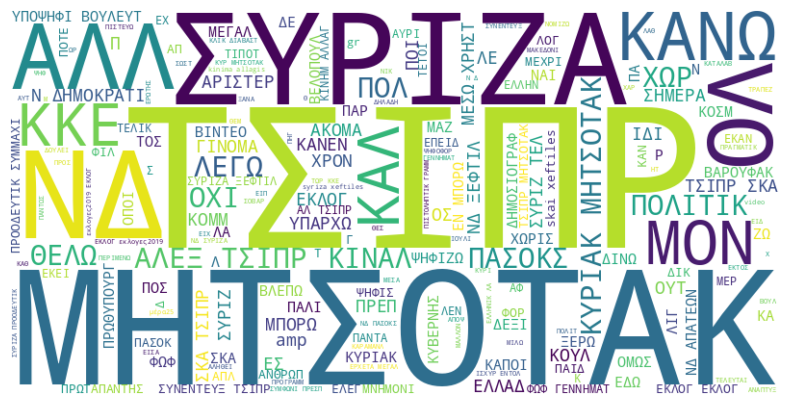

In [4]:
# Create a WordCloud 
text_for_wordcloud = ' '.join([' '.join(line) for line in line_vectors])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_for_wordcloud)

# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [5]:
# Count the frequency of each token
flat_word_vectors = [token for line in line_vectors for token in line]
token_frequency = Counter(flat_word_vectors)

# 10 most common tokens with their frequencies
for token, frequency in token_frequency.most_common(10):
    print(f"{token}: {frequency} times")

ΤΣΙΠΡ: 11139 times
ΜΗΤΣΟΤΑΚ: 9241 times
ΝΔ: 8156 times
ΕΚΛΟΓ: 4599 times
ΣΥΡΙΖΑ: 4467 times
ΚΚΕ: 3515 times
Ν: 3159 times
ΣΥΡΙΖ: 3102 times
ΣΚΑ: 2946 times
ΟΛ: 2804 times


In [6]:
# Set the parameters for the Word2Vec model
vector_size = 100
window_size = 5
min_count = 1
workers = 4

word2vec_model = Word2Vec(sentences=line_vectors, vector_size=vector_size, window=window_size, min_count=min_count, workers=workers)
# word2vec_model.save("word2vec_model.model")

word_vector = word2vec_model.wv['ΚΚΕ']
print("Word vector for 'ΚΚΕ':", word_vector)

Word vector for 'ΚΚΕ': [-1.6241277   0.02099923 -0.93662256 -1.8835396  -0.8218878  -0.78226495
 -1.0593456   1.7632979   0.95000625 -0.98025376 -0.5943028  -1.0992259
 -0.06352264 -0.82714295 -0.33050817 -0.46217528 -0.54252285  0.23663533
 -0.25256118 -2.1707783  -1.4689682  -0.35740176  2.5202022   0.6936049
 -0.03845886 -1.1177285   0.08469192 -1.3620478   0.6229391   0.5366937
  1.1844244   0.6728389  -0.9293882  -1.3501809  -0.56277704  2.1568055
 -0.7997394  -0.76329523 -1.2048755  -2.1629846   1.9236941  -1.2514162
 -1.2955695  -0.10493069 -0.03523085 -0.5797178  -1.7896451   0.49295703
  1.4835463   0.16153271  0.19687884 -0.7685199   1.7524889   0.36404446
 -0.8927831   0.11298665  0.9362067   0.4759325  -0.33823913 -0.54474753
  1.6325691  -0.08667707  0.10340322  1.0814005  -0.6110998  -0.35484636
  0.51013666  1.3164827   0.10630356 -0.3443684  -0.38085997 -0.36437917
  1.6381172   2.2539778   0.9655378   1.7427408   0.6473403  -0.93968475
 -1.2042282  -0.3227743   1.09424

Most semantically similar to word ΝΔ:

     word            similarity score
     ΠΑΙΧΝΙΔΑΚ      0.7517390251159668
     ΣΥΝΤΡΙΠΤΙΚ     0.7516343593597412
     ΔΙΑΓΡΑΦΩ       0.7509975433349609
     ΣΥΡΙΖΑ         0.7499797940254211
     155            0.7481666803359985
     ΤΟΥΜΠΑΛ        0.7459781765937805
     ΓΡΙΦ           0.7436648011207581
     ΔΙΑΣΥΝΔΕΣ      0.7403073310852051
     ΨΗΦΗΣ          0.7395094633102417
     ΚΛΕΦΤ          0.7389461398124695


Most semantically similar to word ΣΥΡΙΖΑ:

     word            similarity score
     ΚΛΗΡΩΣ         0.8209822773933411
     ΔΙΑΛΥ          0.820624828338623
     ΠΟΣΟΣΤ         0.8145901560783386
     ΣΥΡΙΖ          0.8062341213226318
     ΑΖΗΤΗΤ         0.8051565885543823
     ΑΝΑΜΕΣΑ        0.8006429672241211
     ΕΠΕΙΓΟΝΤΩΣ     0.7995772361755371
     ΣΥΝΤΡΙΠΤΙΚ     0.7981833815574646
     ΜΑΚΡΟΒΙ        0.7959696054458618
     gay            0.7958060503005981


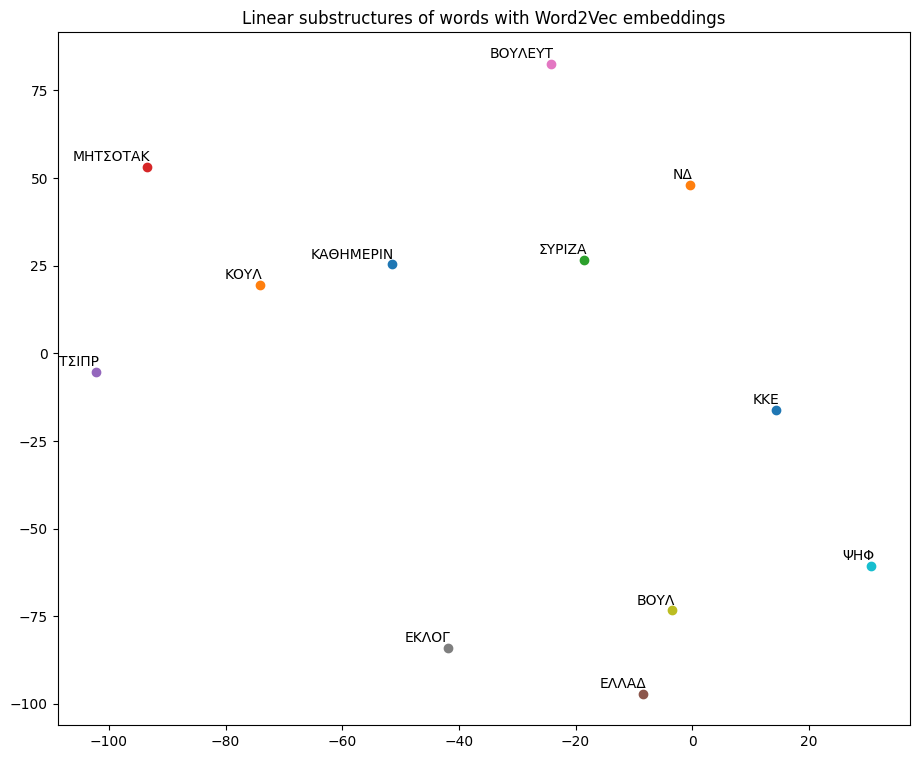

In [7]:
from sklearn.manifold import TSNE
import seaborn as sns

# Word similarities
most_similar_1 = word2vec_model.wv.most_similar('ΝΔ')
most_similar_2 = word2vec_model.wv.most_similar('ΣΥΡΙΖΑ')

print(f'Most semantically similar to word ΝΔ:')
print(f'\n{" "*5}word{" "*10}  similarity score')
print(f'{"="*43}')
for w in most_similar_1:
    print(f'{" "*5}{w[0]:15}{w[1]}')

print(f'\n\nMost semantically similar to word ΣΥΡΙΖΑ:')
print(f'\n{" "*5}word{" "*10}  similarity score')
print(f'{"="*43}')
for w in most_similar_2:
    print(f'{" "*5}{w[0]:15}{w[1]}')

vocab = ["ΚΚΕ", "ΝΔ", "ΣΥΡΙΖΑ", "ΜΗΤΣΟΤΑΚ", "ΤΣΙΠΡ", "ΕΛΛΑΔ", "ΒΟΥΛΕΥΤ", "ΕΚΛΟΓ", "ΒΟΥΛ", "ΨΗΦ", "ΚΑΘΗΜΕΡΙΝ", "ΚΟΥΛ"]

def glove_plot(model):
    labels = []
    wordvecs = []

    for word in vocab:
        wordvecs.append(model.wv[word])
        labels.append(word)
    
    wordvecs = np.array(wordvecs)
    tsne_model = TSNE(perplexity=3, n_components=2, init='pca', random_state=42)
    coordinates = tsne_model.fit_transform(wordvecs)

    x = []
    y = []
    for value in coordinates:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(11, 9)) 
    plt.title('Linear substructures of words with Word2Vec embeddings')
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(2, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

# Visualize word embeddings
glove_plot(word2vec_model)

In [8]:
# Convert the vectors into numerical
vector_size = 100
X = np.array([np.mean(word2vec_model.wv[line], axis=0) if line and all(word in word2vec_model.wv for word in line) else np.zeros(vector_size) for line in line_vectors])
X_valid = np.array([np.mean(word2vec_model.wv[line], axis=0) if line and all(word in word2vec_model.wv for word in line) else np.zeros(vector_size) for line in line_vectors_valid])
X_test_set = np.array([np.mean(word2vec_model.wv[line], axis=0) if line and all(word in word2vec_model.wv for word in line) else np.zeros(vector_size) for line in line_vectors_test_csv])

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['Sentiment'])
y_valid_encoded = label_encoder.transform(df_valid_csv['Sentiment'])

# Convert Sentiment into 0, 1, 2
onehot_encoder = OneHotEncoder(sparse_output=False)  # Explicitly set sparse_output
y_onehot = onehot_encoder.fit_transform(y_encoded.reshape(-1, 1))
y_valid_onehot = onehot_encoder.transform(y_valid_encoded.reshape(-1, 1))

assert (label_encoder.transform(label_encoder.classes_) == np.unique(y_encoded)).all(), "Label encoding mismatch"

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)
X_test_set = scaler.transform(X_test_set)

In [10]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid_onehot, dtype=torch.float32)
X_test_set_tensor = torch.tensor(X_test_set, dtype=torch.float32)

In [11]:
def suggest_hyperparameters(trial): 
    optimizer_name = trial.suggest_categorical("optimizer_name", ["Adam", "AdamW"])
    return optimizer_name

class Net(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out, activation_function):
        super(Net, self).__init__()

        self.linear1 = nn.Linear(D_in, H1)
        self.bn1 = nn.BatchNorm1d(H1)  # Batch normalization layer after the first linear layer
        self.linear2 = nn.Linear(H1, H2)
        self.bn2 = nn.BatchNorm1d(H2)  # Batch normalization layer after the second linear layer
        self.linear3 = nn.Linear(H2, H3)
        self.bn3 = nn.BatchNorm1d(H3)  # Batch normalization layer after the third linear layer
        self.linear4 = nn.Linear(H3, D_out)

        
        if activation_function == "relu":
            self.activation = nn.ReLU()
        elif activation_function == "sigmoid":
            self.activation = nn.Sigmoid()
        elif activation_function == "tanh":
            self.activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.linear1(x))
        x = self.activation(self.linear2(x))
        x = self.activation(self.linear3(x))
        x = self.linear4(x)
        return x

[I 2024-01-23 00:01:31,552] A new study created in memory with name: hyperparameter_optimization


Epoch   1: Loss = 43.56371
Epoch   2: Loss = 41.88399
Epoch   3: Loss = 41.68973
Epoch   4: Loss = 41.56504
Epoch   5: Loss = 41.49674
Epoch   6: Loss = 41.40408
Epoch   7: Loss = 41.32263
Epoch   8: Loss = 41.23663
Epoch   9: Loss = 41.17748
Epoch  10: Loss = 41.06305


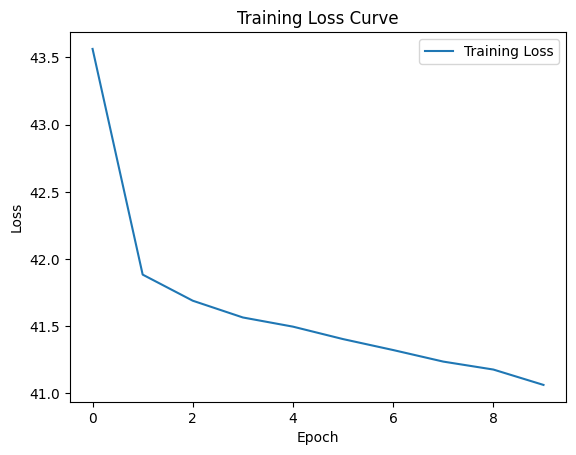

[I 2024-01-23 00:01:43,445] Trial 0 finished with value: 41.06305498014891 and parameters: {'optimizer_name': 'AdamW', 'learning_rate': 0.0006796641438223921, 'activation_function': 'relu'}. Best is trial 0 with value: 41.06305498014891.


Epoch   1: Loss = 42.90361
Epoch   2: Loss = 42.15259
Epoch   3: Loss = 41.99589
Epoch   4: Loss = 41.92739
Epoch   5: Loss = 41.87331
Epoch   6: Loss = 41.80837
Epoch   7: Loss = 41.74244
Epoch   8: Loss = 41.75039
Epoch   9: Loss = 41.71997
Epoch  10: Loss = 41.70535


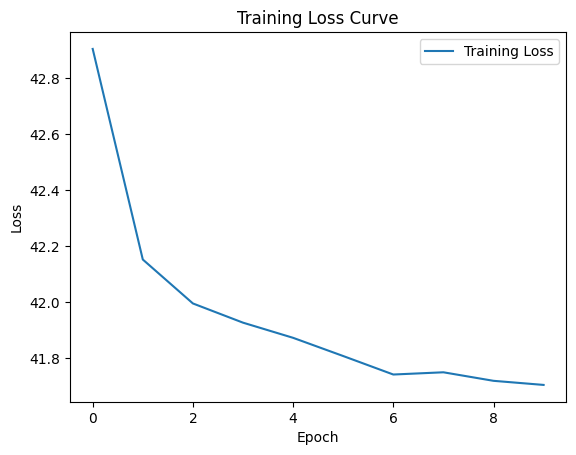

[I 2024-01-23 00:01:54,571] Trial 1 finished with value: 41.70534577848609 and parameters: {'optimizer_name': 'AdamW', 'learning_rate': 0.011638672124129706, 'activation_function': 'sigmoid'}. Best is trial 0 with value: 41.06305498014891.


Epoch   1: Loss = 47.54429
Epoch   2: Loss = 43.18078
Epoch   3: Loss = 42.82330
Epoch   4: Loss = 42.61970
Epoch   5: Loss = 42.46300
Epoch   6: Loss = 42.33281
Epoch   7: Loss = 42.21594
Epoch   8: Loss = 42.11881
Epoch   9: Loss = 42.02544
Epoch  10: Loss = 41.95295


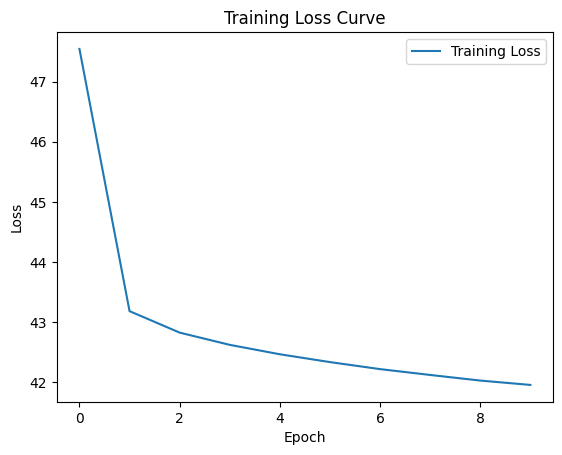

[I 2024-01-23 00:02:05,489] Trial 2 finished with value: 41.95295065667431 and parameters: {'optimizer_name': 'Adam', 'learning_rate': 2.117445064141857e-05, 'activation_function': 'relu'}. Best is trial 0 with value: 41.06305498014891.


Epoch   1: Loss = 42.85755
Epoch   2: Loss = 42.15253
Epoch   3: Loss = 42.01757
Epoch   4: Loss = 41.86271
Epoch   5: Loss = 41.79880
Epoch   6: Loss = 41.76551
Epoch   7: Loss = 41.65066
Epoch   8: Loss = 41.67414
Epoch   9: Loss = 41.63618
Epoch  10: Loss = 41.49122


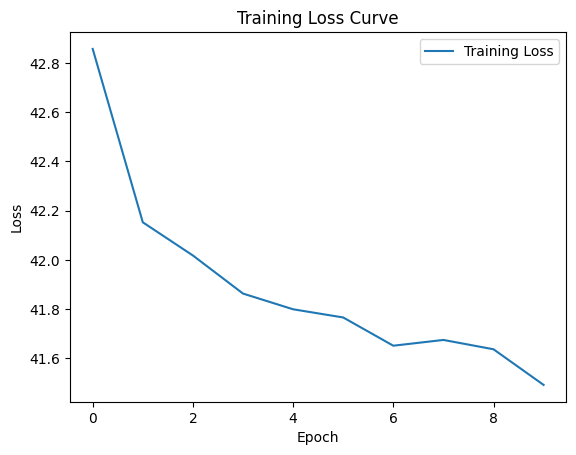

[I 2024-01-23 00:02:17,179] Trial 3 finished with value: 41.491216226436165 and parameters: {'optimizer_name': 'Adam', 'learning_rate': 0.012112481127555605, 'activation_function': 'sigmoid'}. Best is trial 0 with value: 41.06305498014891.


Epoch   1: Loss = 52.93723
Epoch   2: Loss = 47.62692
Epoch   3: Loss = 44.32726
Epoch   4: Loss = 42.80766
Epoch   5: Loss = 42.34806
Epoch   6: Loss = 42.22610
Epoch   7: Loss = 42.17581
Epoch   8: Loss = 42.14724
Epoch   9: Loss = 42.12009
Epoch  10: Loss = 42.10193


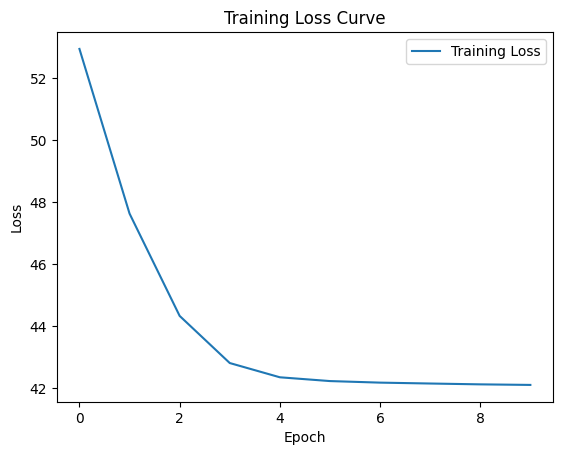

[I 2024-01-23 00:02:28,110] Trial 4 finished with value: 42.101930301782865 and parameters: {'optimizer_name': 'Adam', 'learning_rate': 1.1409473834161476e-05, 'activation_function': 'tanh'}. Best is trial 0 with value: 41.06305498014891.


Epoch   1: Loss = 48.41353
Epoch   2: Loss = 43.18065
Epoch   3: Loss = 42.75196
Epoch   4: Loss = 42.45583
Epoch   5: Loss = 42.23091
Epoch   6: Loss = 42.05379
Epoch   7: Loss = 41.88931
Epoch   8: Loss = 41.76762
Epoch   9: Loss = 41.67143
Epoch  10: Loss = 41.58604


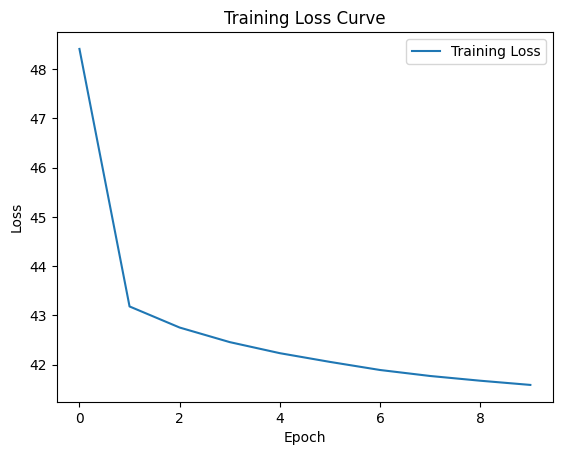

[I 2024-01-23 00:02:38,950] Trial 5 finished with value: 41.586040355232605 and parameters: {'optimizer_name': 'Adam', 'learning_rate': 5.3275982801101996e-05, 'activation_function': 'relu'}. Best is trial 0 with value: 41.06305498014891.


Epoch   1: Loss = 42.70100
Epoch   2: Loss = 42.41438
Epoch   3: Loss = 42.33008
Epoch   4: Loss = 42.27824
Epoch   5: Loss = 42.23725
Epoch   6: Loss = 42.22211
Epoch   7: Loss = 42.16782
Epoch   8: Loss = 42.15068
Epoch   9: Loss = 42.12340
Epoch  10: Loss = 42.11158


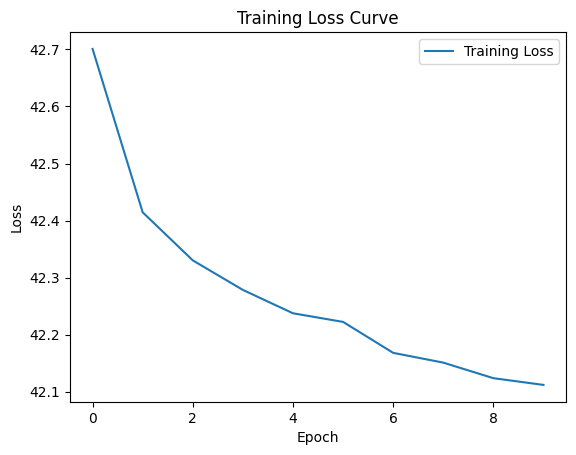

[I 2024-01-23 00:02:51,256] Trial 6 finished with value: 42.11157603034807 and parameters: {'optimizer_name': 'AdamW', 'learning_rate': 0.00015478649746983368, 'activation_function': 'sigmoid'}. Best is trial 0 with value: 41.06305498014891.


Epoch   1: Loss = 42.79017
Epoch   2: Loss = 42.05634
Epoch   3: Loss = 42.02116
Epoch   4: Loss = 41.96820
Epoch   5: Loss = 41.96475
Epoch   6: Loss = 41.91905
Epoch   7: Loss = 41.87850
Epoch   8: Loss = 41.79638
Epoch   9: Loss = 41.71425
Epoch  10: Loss = 41.71295


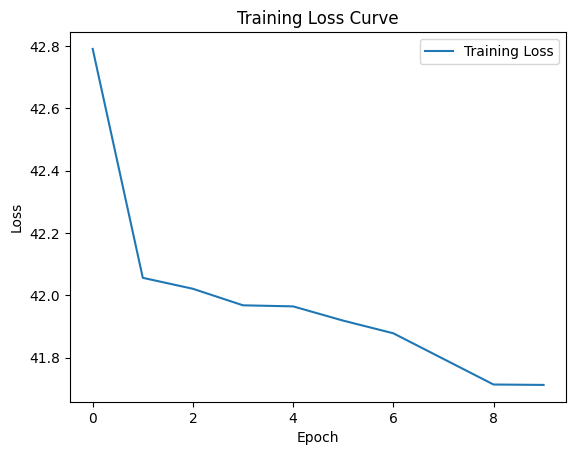

[I 2024-01-23 00:03:04,352] Trial 7 finished with value: 41.712950052652815 and parameters: {'optimizer_name': 'AdamW', 'learning_rate': 0.004530061317962721, 'activation_function': 'relu'}. Best is trial 0 with value: 41.06305498014891.


Epoch   1: Loss = 43.42095
Epoch   2: Loss = 42.41851
Epoch   3: Loss = 42.35271
Epoch   4: Loss = 42.29751
Epoch   5: Loss = 42.23901
Epoch   6: Loss = 42.21074
Epoch   7: Loss = 42.17208
Epoch   8: Loss = 42.15313
Epoch   9: Loss = 42.11493
Epoch  10: Loss = 42.09556


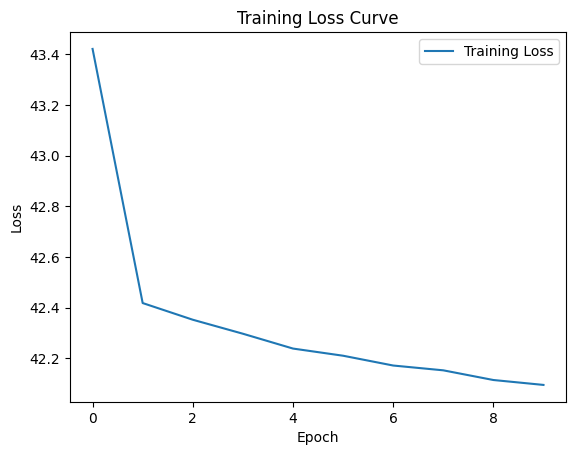

[I 2024-01-23 00:03:15,344] Trial 8 finished with value: 42.09555975734927 and parameters: {'optimizer_name': 'Adam', 'learning_rate': 0.00022579271775059436, 'activation_function': 'sigmoid'}. Best is trial 0 with value: 41.06305498014891.


Epoch   1: Loss = 44.51361
Epoch   2: Loss = 43.33911
Epoch   3: Loss = 43.31587
Epoch   4: Loss = 43.29899
Epoch   5: Loss = 43.28837
Epoch   6: Loss = 43.58489
Epoch   7: Loss = 43.32234
Epoch   8: Loss = 43.45963
Epoch   9: Loss = 43.42576
Epoch  10: Loss = 43.47413


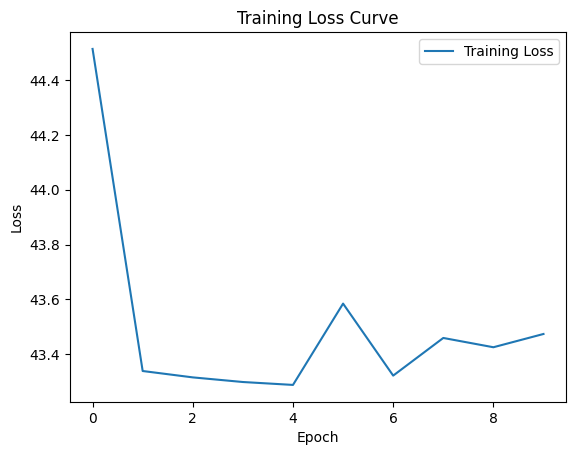

[I 2024-01-23 00:03:26,361] Trial 9 finished with value: 43.47413202144173 and parameters: {'optimizer_name': 'Adam', 'learning_rate': 0.08616794026819677, 'activation_function': 'sigmoid'}. Best is trial 0 with value: 41.06305498014891.


Epoch   1: Loss = 42.89549
Epoch   2: Loss = 42.28450
Epoch   3: Loss = 42.12562
Epoch   4: Loss = 42.02203
Epoch   5: Loss = 41.95568
Epoch   6: Loss = 41.88451
Epoch   7: Loss = 41.79420
Epoch   8: Loss = 41.81225
Epoch   9: Loss = 41.70262
Epoch  10: Loss = 41.64750


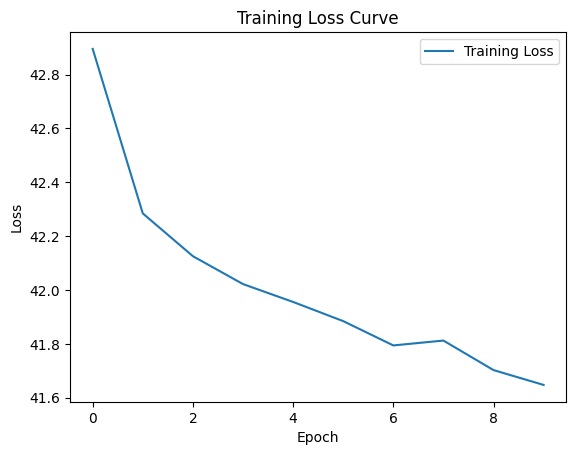

[I 2024-01-23 00:03:37,619] Trial 10 finished with value: 41.64750242441502 and parameters: {'optimizer_name': 'AdamW', 'learning_rate': 0.0011856772638193763, 'activation_function': 'tanh'}. Best is trial 0 with value: 41.06305498014891.


Epoch   1: Loss = 42.98814
Epoch   2: Loss = 42.76377
Epoch   3: Loss = 42.78378
Epoch   4: Loss = 42.75091
Epoch   5: Loss = 42.75616
Epoch   6: Loss = 42.73960
Epoch   7: Loss = 42.78908
Epoch   8: Loss = 42.76691
Epoch   9: Loss = 42.78007
Epoch  10: Loss = 42.74853


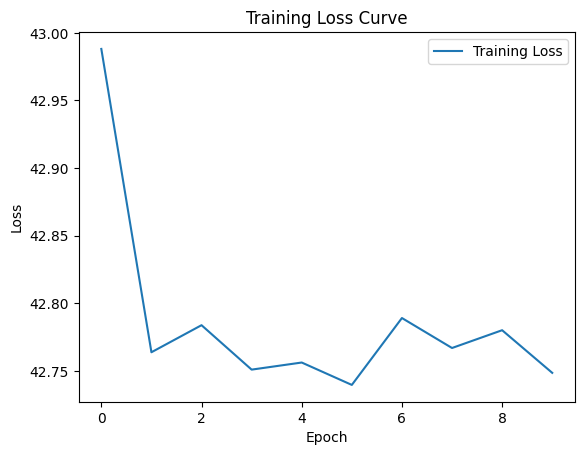

[I 2024-01-23 00:03:50,431] Trial 11 finished with value: 42.74853467316607 and parameters: {'optimizer_name': 'AdamW', 'learning_rate': 0.02054646766108, 'activation_function': 'relu'}. Best is trial 0 with value: 41.06305498014891.


Epoch   1: Loss = 42.78110
Epoch   2: Loss = 42.35500
Epoch   3: Loss = 42.18497
Epoch   4: Loss = 41.97212
Epoch   5: Loss = 41.85225
Epoch   6: Loss = 41.76180
Epoch   7: Loss = 41.64934
Epoch   8: Loss = 41.61424
Epoch   9: Loss = 41.55877
Epoch  10: Loss = 41.51415


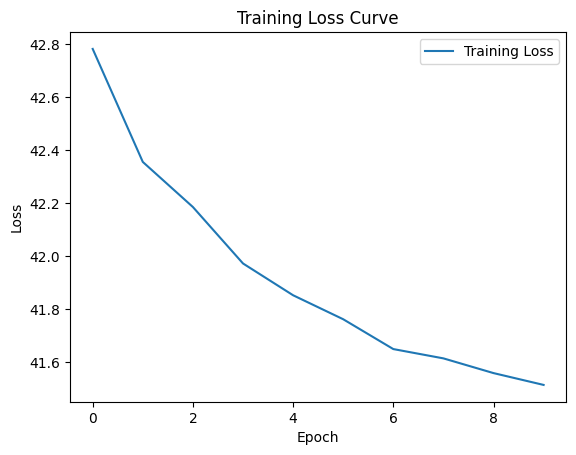

[I 2024-01-23 00:04:01,679] Trial 12 finished with value: 41.51415275173937 and parameters: {'optimizer_name': 'AdamW', 'learning_rate': 0.0012283725516558136, 'activation_function': 'sigmoid'}. Best is trial 0 with value: 41.06305498014891.


Epoch   1: Loss = 42.60953
Epoch   2: Loss = 42.04550
Epoch   3: Loss = 41.98730
Epoch   4: Loss = 41.86929
Epoch   5: Loss = 41.79496
Epoch   6: Loss = 41.78808
Epoch   7: Loss = 41.69783
Epoch   8: Loss = 41.66949
Epoch   9: Loss = 41.66032
Epoch  10: Loss = 41.57349


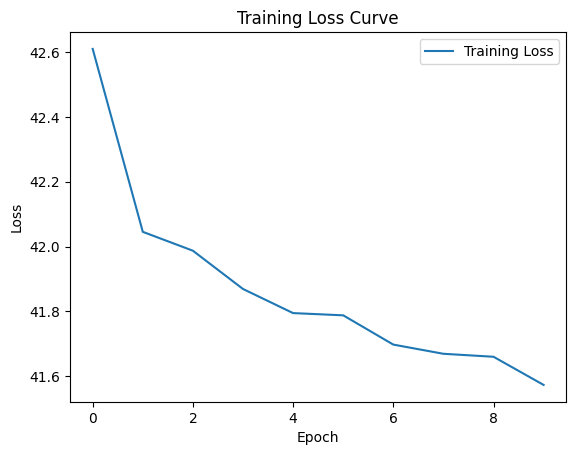

[I 2024-01-23 00:04:13,149] Trial 13 finished with value: 41.5734884270414 and parameters: {'optimizer_name': 'Adam', 'learning_rate': 0.0037192397884765215, 'activation_function': 'relu'}. Best is trial 0 with value: 41.06305498014891.


Epoch   1: Loss = 45.95662
Epoch   2: Loss = 42.22133
Epoch   3: Loss = 42.11011
Epoch   4: Loss = 42.01539
Epoch   5: Loss = 41.98206
Epoch   6: Loss = 41.88526
Epoch   7: Loss = 41.86688
Epoch   8: Loss = 41.79781
Epoch   9: Loss = 41.73243
Epoch  10: Loss = 41.68855


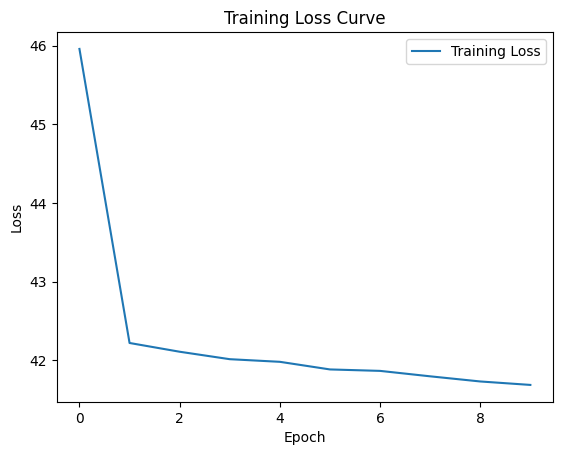

[I 2024-01-23 00:04:24,767] Trial 14 finished with value: 41.688548700257684 and parameters: {'optimizer_name': 'Adam', 'learning_rate': 0.0003298268816262973, 'activation_function': 'tanh'}. Best is trial 0 with value: 41.06305498014891.


Epoch   1: Loss = 44.56287
Epoch   2: Loss = 42.75394
Epoch   3: Loss = 42.80476
Epoch   4: Loss = 42.79718
Epoch   5: Loss = 42.91024
Epoch   6: Loss = 43.00793
Epoch   7: Loss = 42.96701
Epoch   8: Loss = 42.92627
Epoch   9: Loss = 43.34402
Epoch  10: Loss = 43.88174


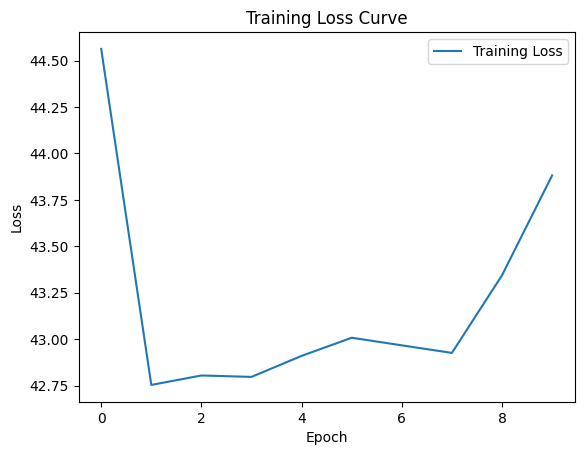

[I 2024-01-23 00:04:36,984] Trial 15 finished with value: 43.88173962055856 and parameters: {'optimizer_name': 'AdamW', 'learning_rate': 0.06917878917325154, 'activation_function': 'sigmoid'}. Best is trial 0 with value: 41.06305498014891.


Epoch   1: Loss = 42.93494
Epoch   2: Loss = 42.13986
Epoch   3: Loss = 41.95825
Epoch   4: Loss = 41.90734
Epoch   5: Loss = 41.84435
Epoch   6: Loss = 41.85739
Epoch   7: Loss = 41.78355
Epoch   8: Loss = 41.77423
Epoch   9: Loss = 41.70556
Epoch  10: Loss = 41.67159


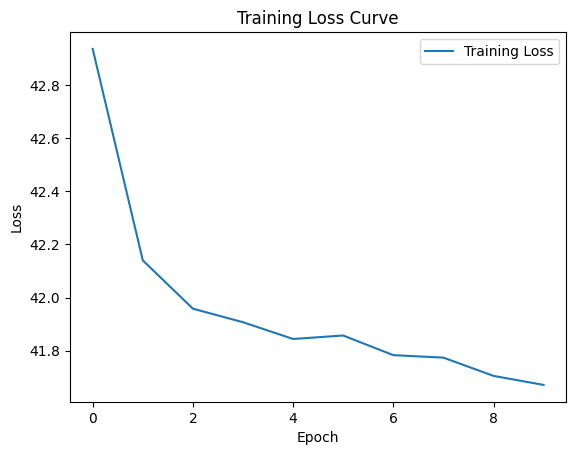

[I 2024-01-23 00:04:48,901] Trial 16 finished with value: 41.671586565575744 and parameters: {'optimizer_name': 'AdamW', 'learning_rate': 0.004475075219216781, 'activation_function': 'relu'}. Best is trial 0 with value: 41.06305498014891.


Epoch   1: Loss = 43.38773
Epoch   2: Loss = 42.80821
Epoch   3: Loss = 42.76052
Epoch   4: Loss = 42.75736
Epoch   5: Loss = 42.78214
Epoch   6: Loss = 42.74868
Epoch   7: Loss = 42.75106
Epoch   8: Loss = 42.79585
Epoch   9: Loss = 42.76307
Epoch  10: Loss = 42.80035


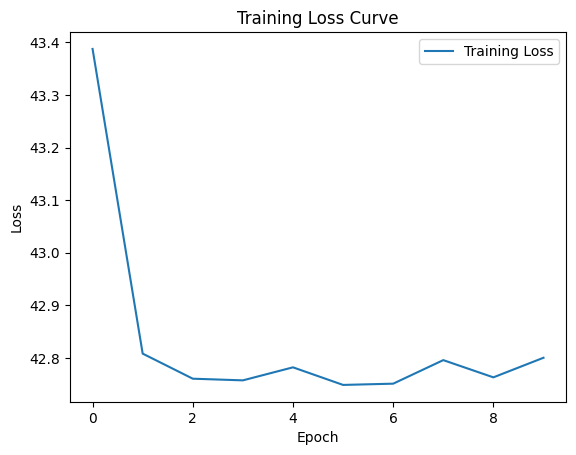

[I 2024-01-23 00:05:01,428] Trial 17 finished with value: 42.80035054735742 and parameters: {'optimizer_name': 'Adam', 'learning_rate': 0.023993236612225816, 'activation_function': 'relu'}. Best is trial 0 with value: 41.06305498014891.


Epoch   1: Loss = 45.48658
Epoch   2: Loss = 42.43578
Epoch   3: Loss = 42.36656
Epoch   4: Loss = 42.28296
Epoch   5: Loss = 42.24423
Epoch   6: Loss = 42.18784
Epoch   7: Loss = 42.12986
Epoch   8: Loss = 42.06318
Epoch   9: Loss = 42.02569
Epoch  10: Loss = 41.99911


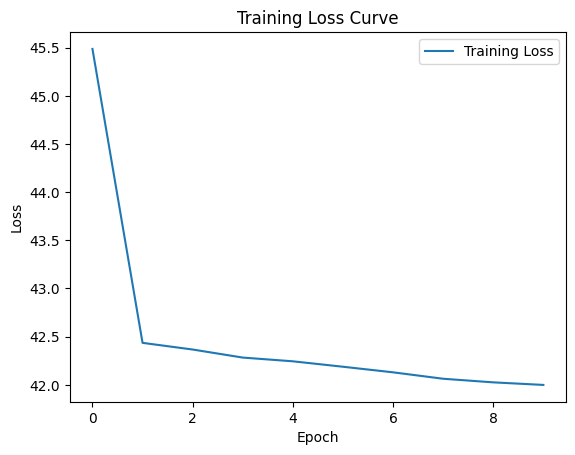

[I 2024-01-23 00:05:12,912] Trial 18 finished with value: 41.99911192515011 and parameters: {'optimizer_name': 'AdamW', 'learning_rate': 0.0005984108012285446, 'activation_function': 'sigmoid'}. Best is trial 0 with value: 41.06305498014891.


Epoch   1: Loss = 46.53735
Epoch   2: Loss = 42.22645
Epoch   3: Loss = 42.10070
Epoch   4: Loss = 42.02894
Epoch   5: Loss = 41.97401
Epoch   6: Loss = 41.93377
Epoch   7: Loss = 41.89616
Epoch   8: Loss = 41.86537
Epoch   9: Loss = 41.83113
Epoch  10: Loss = 41.80525


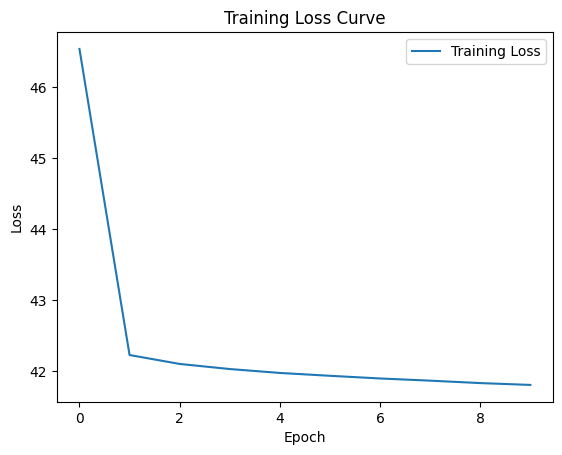

[I 2024-01-23 00:05:24,251] Trial 19 finished with value: 41.805247352633415 and parameters: {'optimizer_name': 'Adam', 'learning_rate': 7.132378379443885e-05, 'activation_function': 'tanh'}. Best is trial 0 with value: 41.06305498014891.


Epoch   1: Loss = 42.91630
Epoch   2: Loss = 41.93714
Epoch   3: Loss = 41.80265
Epoch   4: Loss = 41.66728
Epoch   5: Loss = 41.59415
Epoch   6: Loss = 41.51948
Epoch   7: Loss = 41.46392
Epoch   8: Loss = 41.40727
Epoch   9: Loss = 41.34358
Epoch  10: Loss = 41.26390


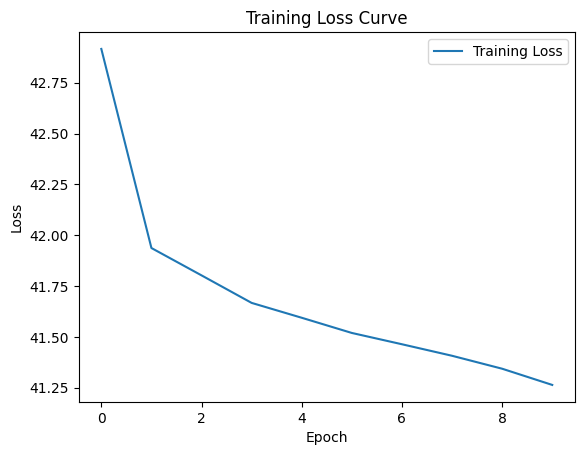

[I 2024-01-23 00:05:35,371] Trial 20 finished with value: 41.26389657566121 and parameters: {'optimizer_name': 'Adam', 'learning_rate': 0.001545092318417565, 'activation_function': 'relu'}. Best is trial 0 with value: 41.06305498014891.


Epoch   1: Loss = 43.04027
Epoch   2: Loss = 41.97462
Epoch   3: Loss = 41.83964
Epoch   4: Loss = 41.71804
Epoch   5: Loss = 41.63657
Epoch   6: Loss = 41.53447
Epoch   7: Loss = 41.53502
Epoch   8: Loss = 41.43812
Epoch   9: Loss = 41.37941
Epoch  10: Loss = 41.32162


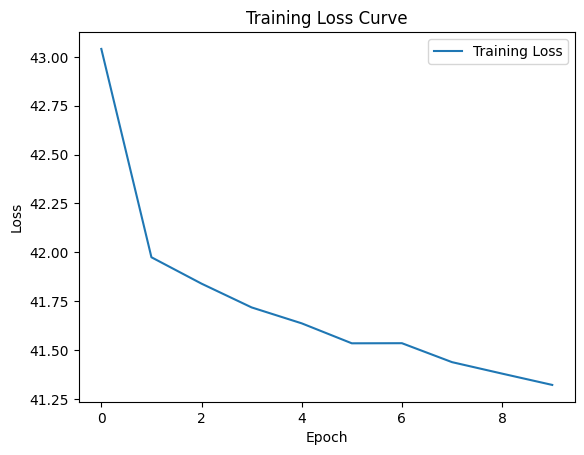

[I 2024-01-23 00:05:46,831] Trial 21 finished with value: 41.321623681414074 and parameters: {'optimizer_name': 'Adam', 'learning_rate': 0.0017371961155962326, 'activation_function': 'relu'}. Best is trial 0 with value: 41.06305498014891.


Epoch   1: Loss = 42.70025
Epoch   2: Loss = 41.93332
Epoch   3: Loss = 41.76174
Epoch   4: Loss = 41.66168
Epoch   5: Loss = 41.61862
Epoch   6: Loss = 41.52837
Epoch   7: Loss = 41.44452
Epoch   8: Loss = 41.39989
Epoch   9: Loss = 41.31883
Epoch  10: Loss = 41.28643


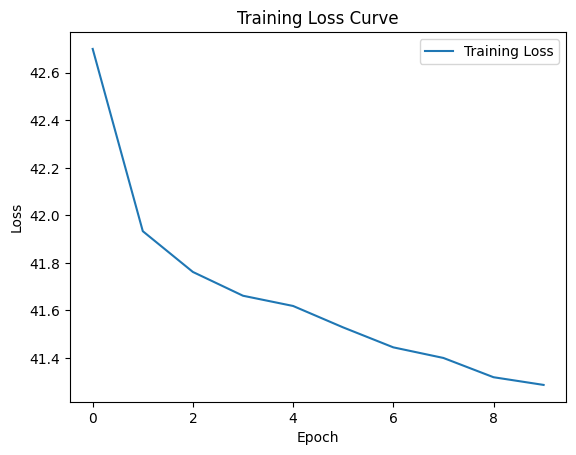

[I 2024-01-23 00:05:58,220] Trial 22 finished with value: 41.28642874305425 and parameters: {'optimizer_name': 'Adam', 'learning_rate': 0.0016694740705991082, 'activation_function': 'relu'}. Best is trial 0 with value: 41.06305498014891.


Epoch   1: Loss = 42.64888
Epoch   2: Loss = 41.96610
Epoch   3: Loss = 41.82883
Epoch   4: Loss = 41.71947
Epoch   5: Loss = 41.68080
Epoch   6: Loss = 41.64156
Epoch   7: Loss = 41.58135
Epoch   8: Loss = 41.49563
Epoch   9: Loss = 41.44328
Epoch  10: Loss = 41.41557


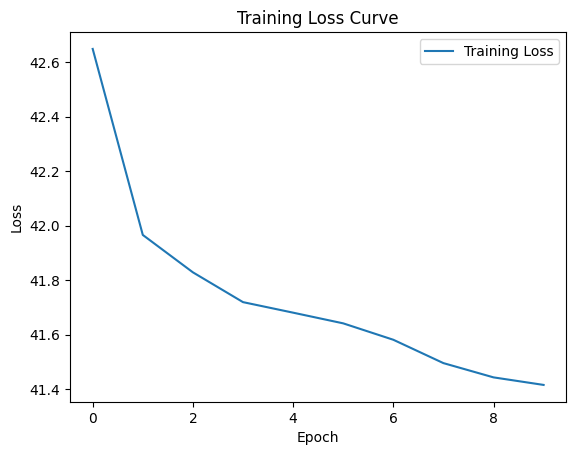

[I 2024-01-23 00:06:09,515] Trial 23 finished with value: 41.41556666511636 and parameters: {'optimizer_name': 'Adam', 'learning_rate': 0.002556519630433344, 'activation_function': 'relu'}. Best is trial 0 with value: 41.06305498014891.


Epoch   1: Loss = 42.86387
Epoch   2: Loss = 41.80827
Epoch   3: Loss = 41.66266
Epoch   4: Loss = 41.55063
Epoch   5: Loss = 41.45945
Epoch   6: Loss = 41.34825
Epoch   7: Loss = 41.26194
Epoch   8: Loss = 41.18145
Epoch   9: Loss = 41.07100
Epoch  10: Loss = 40.99602


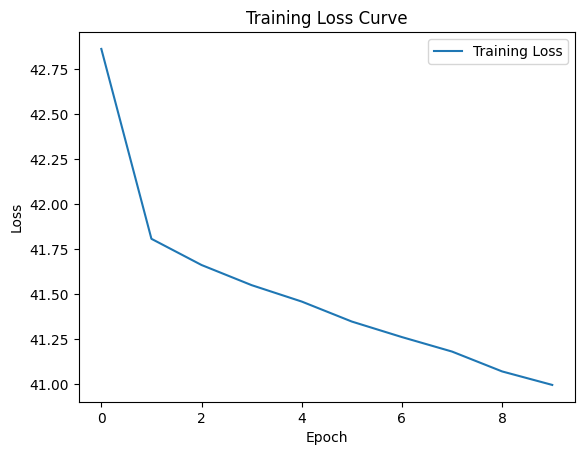

[I 2024-01-23 00:06:20,354] Trial 24 finished with value: 40.99601691466752 and parameters: {'optimizer_name': 'Adam', 'learning_rate': 0.0005079730894025651, 'activation_function': 'relu'}. Best is trial 24 with value: 40.99601691466752.


Epoch   1: Loss = 43.61109
Epoch   2: Loss = 41.87807
Epoch   3: Loss = 41.73024
Epoch   4: Loss = 41.60936
Epoch   5: Loss = 41.50803
Epoch   6: Loss = 41.42906
Epoch   7: Loss = 41.37375
Epoch   8: Loss = 41.28189
Epoch   9: Loss = 41.18691
Epoch  10: Loss = 41.13832


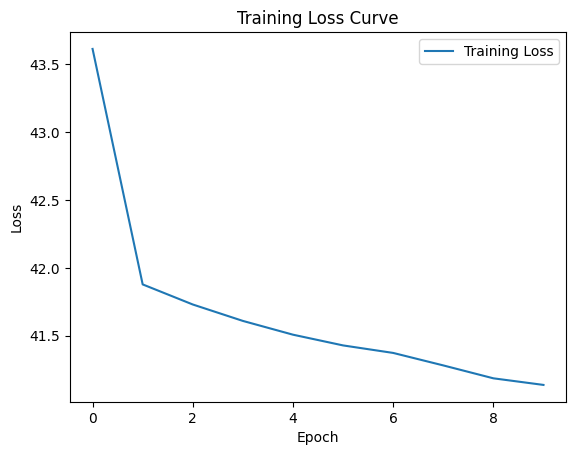

[I 2024-01-23 00:06:31,534] Trial 25 finished with value: 41.1383155839412 and parameters: {'optimizer_name': 'Adam', 'learning_rate': 0.0005771501065048424, 'activation_function': 'relu'}. Best is trial 24 with value: 40.99601691466752.


Epoch   1: Loss = 44.18566
Epoch   2: Loss = 41.98116
Epoch   3: Loss = 41.71595
Epoch   4: Loss = 41.59991
Epoch   5: Loss = 41.50356
Epoch   6: Loss = 41.42084
Epoch   7: Loss = 41.34718
Epoch   8: Loss = 41.26264
Epoch   9: Loss = 41.20492
Epoch  10: Loss = 41.08361


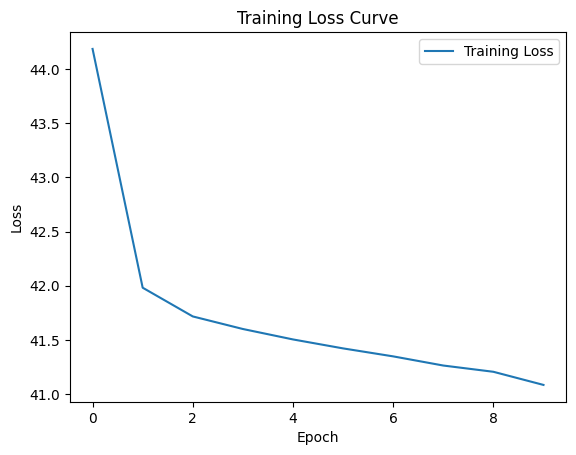

[I 2024-01-23 00:06:42,805] Trial 26 finished with value: 41.083614032861966 and parameters: {'optimizer_name': 'AdamW', 'learning_rate': 0.000526360284912797, 'activation_function': 'relu'}. Best is trial 24 with value: 40.99601691466752.


Epoch   1: Loss = 44.35600
Epoch   2: Loss = 42.42629
Epoch   3: Loss = 42.06016
Epoch   4: Loss = 41.84015
Epoch   5: Loss = 41.71122
Epoch   6: Loss = 41.60490
Epoch   7: Loss = 41.52716
Epoch   8: Loss = 41.45202
Epoch   9: Loss = 41.38629
Epoch  10: Loss = 41.33132


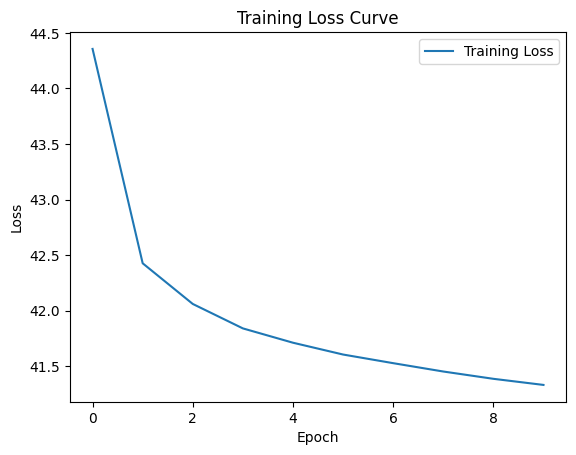

[I 2024-01-23 00:06:54,150] Trial 27 finished with value: 41.331319442482496 and parameters: {'optimizer_name': 'AdamW', 'learning_rate': 0.00010208870275849041, 'activation_function': 'relu'}. Best is trial 24 with value: 40.99601691466752.


Epoch   1: Loss = 42.90646
Epoch   2: Loss = 41.83086
Epoch   3: Loss = 41.65027
Epoch   4: Loss = 41.55388
Epoch   5: Loss = 41.44976
Epoch   6: Loss = 41.38216
Epoch   7: Loss = 41.28419
Epoch   8: Loss = 41.21724
Epoch   9: Loss = 41.07191
Epoch  10: Loss = 40.99398


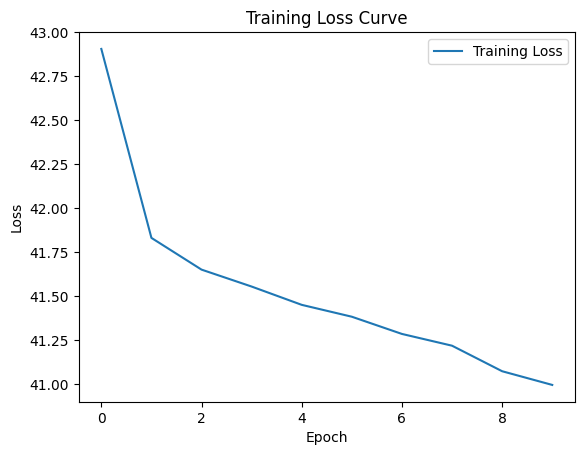

[I 2024-01-23 00:07:05,791] Trial 28 finished with value: 40.99398315629584 and parameters: {'optimizer_name': 'AdamW', 'learning_rate': 0.0006429998871081795, 'activation_function': 'relu'}. Best is trial 28 with value: 40.99398315629584.


Epoch   1: Loss = 43.63531
Epoch   2: Loss = 41.92696
Epoch   3: Loss = 41.67308
Epoch   4: Loss = 41.53637
Epoch   5: Loss = 41.45468
Epoch   6: Loss = 41.37735
Epoch   7: Loss = 41.27490
Epoch   8: Loss = 41.17084
Epoch   9: Loss = 41.12913
Epoch  10: Loss = 41.03275


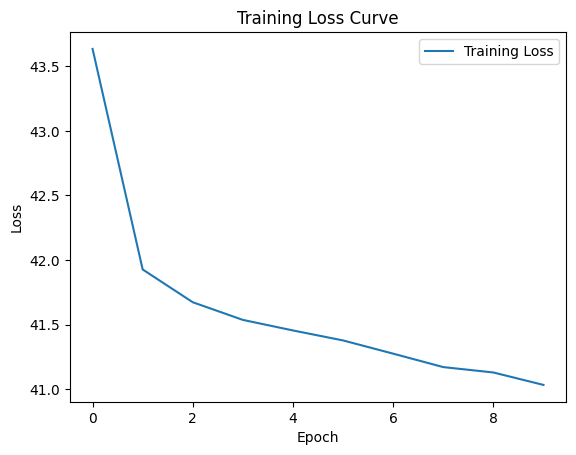

[I 2024-01-23 00:07:17,148] Trial 29 finished with value: 41.032753065683956 and parameters: {'optimizer_name': 'AdamW', 'learning_rate': 0.0002942966022575666, 'activation_function': 'relu'}. Best is trial 28 with value: 40.99398315629584.


best hyperparameters: {'optimizer_name': 'AdamW', 'learning_rate': 0.0006429998871081795, 'activation_function': 'relu'}


In [12]:
# Optuna

def objective(trial):    
    optimizer_name = suggest_hyperparameters(trial)

    # Define layer sizes
    D_in = X_train.shape[1]  # Assuming X_train is your training data
    H1 = 128
    H2 = 64
    H3 = 32
    D_out = y_train.shape[1]  # Adjust D_out based on the number of classes

    # Suggested learning rate
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    activation_function = trial.suggest_categorical("activation_function", ["relu", "sigmoid", "tanh"])

    # Initialize model, loss, optimizer
    model = Net(D_in, H1, H2, H3, D_out, activation_function)
    loss_func = nn.MSELoss(reduction='sum')
    
    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == "AdamW":
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True) 

    epoch_losses = []

    for epoch in range(10):
        batch_losses = []

        for x_batch, y_batch in dataloader:
            y_pred = model(x_batch)
            
            loss = loss_func(y_pred, y_batch)
            batch_losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1:3}: Loss = {sum(batch_losses)/len(dataloader):.5f}")

        epoch_loss = sum(batch_losses)/len(dataloader)
        epoch_losses.append(epoch_loss)
        
    plot_loss_curve(epoch_losses)
    return epoch_loss

study = optuna.create_study(direction='minimize', study_name='hyperparameter_optimization')
study.optimize(objective, n_trials=30)

# Best hyperparameters
best_params = study.best_trial.params
print('best hyperparameters:', best_params)

In [13]:
# Use the best hyperparameters from Optuna
best_optimizer_name = best_params["optimizer_name"]
best_learning_rate = best_params["learning_rate"]

# Define layer sizes
D_in = X_train.shape[1]
H1 = 128
H2 = 64
H3 = 32
D_out = y_train.shape[1]  # D_out based on the number of classes

# Initialize the neural network with the best hyperparameters
best_model = Net(D_in, H1, H2, H3, D_out, 'tanh')

best_loss_func = nn.MSELoss(reduction='sum')
if best_optimizer_name == "Adam":
    best_optimizer = torch.optim.Adam(best_model.parameters(), lr=best_learning_rate)
elif best_optimizer_name == "AdamW":
    best_optimizer = torch.optim.AdamW(best_model.parameters(), lr=best_learning_rate)
elif best_optimizer_name == "SGD":
    best_optimizer = torch.optim.SGD(best_model.parameters(), lr=best_learning_rate)

# Initialize dataloader
best_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
best_dataloader = torch.utils.data.DataLoader(best_dataset, batch_size=64, shuffle=True) 

# Train the model with the best hyperparameters
for epoch in range(10):
    batch_losses = []

    for x_batch, y_batch in best_dataloader:
        y_pred = best_model(x_batch)
        
        loss = best_loss_func(y_pred, y_batch)
        batch_losses.append(loss.item())

        best_optimizer.zero_grad()
        loss.backward()
        best_optimizer.step()

    print(f"Epoch {epoch + 1:3}: Loss = {sum(batch_losses)/len(best_dataloader):.5f}")

Epoch   1: Loss = 43.42031
Epoch   2: Loss = 42.23246
Epoch   3: Loss = 42.05297
Epoch   4: Loss = 41.98421
Epoch   5: Loss = 41.92979
Epoch   6: Loss = 41.83613
Epoch   7: Loss = 41.77836
Epoch   8: Loss = 41.69984
Epoch   9: Loss = 41.60075
Epoch  10: Loss = 41.55488


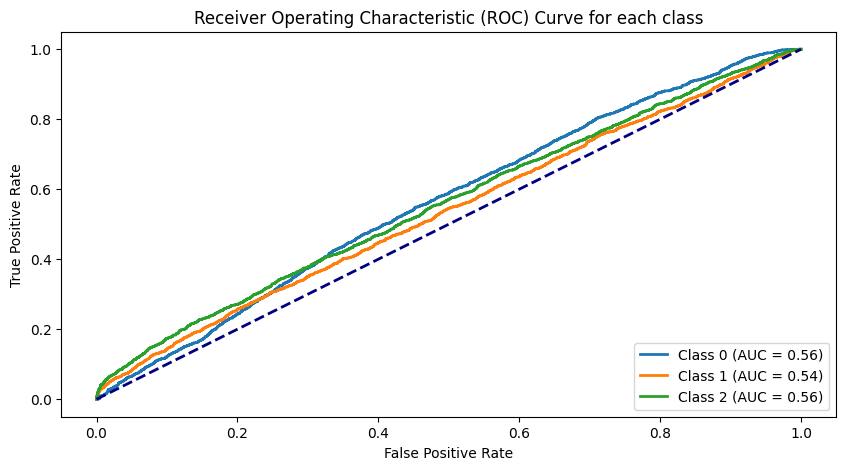

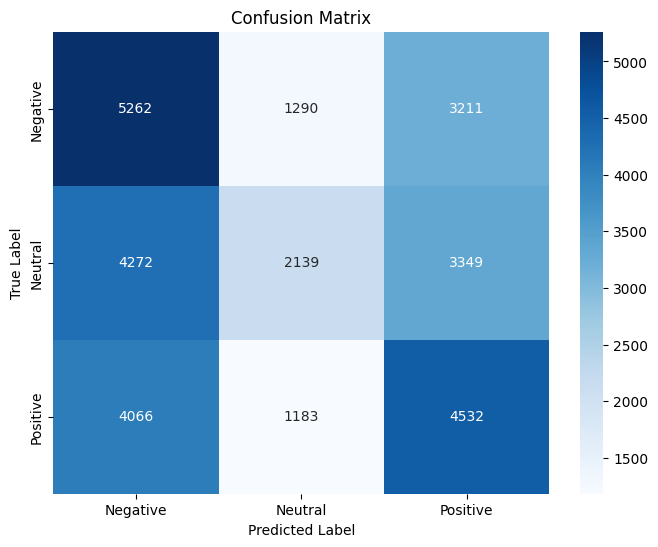

Training Accuracy: 0.4072140322
Classification Report (Training Dataset):
              precision    recall  f1-score   support

    Negative       0.39      0.54      0.45      9763
     Neutral       0.46      0.22      0.30      9760
    Positive       0.41      0.46      0.43      9781

    accuracy                           0.41     29304
   macro avg       0.42      0.41      0.39     29304
weighted avg       0.42      0.41      0.39     29304



In [14]:
# Evaluate the model on the training set
best_model.eval()
correct_predictions = 0
total_samples = 0
all_true_labels = []
all_pred_labels = []

with torch.no_grad():
    for x_train_batch, y_train_batch in best_dataloader:
        y_train_pred = best_model(x_train_batch)
        _, predicted = torch.max(y_train_pred, 1)

        total_samples += y_train_batch.size(0)
        correct_predictions += (predicted == torch.argmax(y_train_batch, 1)).sum().item()
        all_true_labels.extend(torch.argmax(y_train_batch, 1).cpu().numpy())
        all_pred_labels.extend(predicted.cpu().numpy())

training_accuracy = correct_predictions / total_samples

# Plot ROC Curve
plot_roc_curve(best_model, X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor)

# Plot Confusion Matrix
y_train_labels = torch.argmax(y_train_tensor, dim=1).numpy()
plot_confusion_matrix(best_model, X_train_tensor, y_train_labels)

class_names = ['Negative', 'Neutral', 'Positive']
classification_report_str = classification_report(all_true_labels, all_pred_labels, target_names=class_names)

print(f"Training Accuracy: {training_accuracy:.10f}")
print("Classification Report (Training Dataset):")
print(classification_report_str)

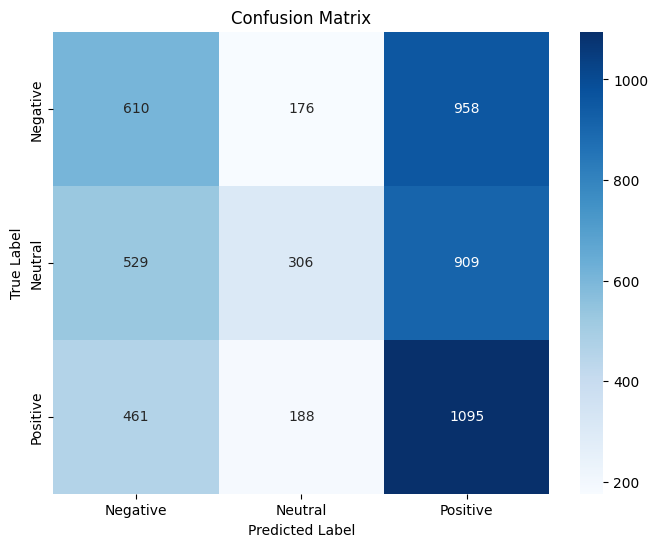

Validation Accuracy: 0.3843654434
Classification Report:
              precision    recall  f1-score   support

    Negative       0.38      0.35      0.36      1744
     Neutral       0.46      0.18      0.25      1744
    Positive       0.37      0.63      0.47      1744

    accuracy                           0.38      5232
   macro avg       0.40      0.38      0.36      5232
weighted avg       0.40      0.38      0.36      5232



In [15]:
validation_dataset = torch.utils.data.TensorDataset(X_valid_tensor, y_valid_tensor)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=64, shuffle=False)  # Note: No need to shuffle for validation

# Evaluate the model on the validation set
best_model.eval()
correct_predictions = 0
total_samples = 0
all_true_labels = []
all_pred_labels = []

with torch.no_grad():
    for x_val_batch, y_val_batch in validation_dataloader:
        y_val_pred = best_model(x_val_batch)
        _, predicted = torch.max(y_val_pred, 1)

        total_samples += y_val_batch.size(0)
        correct_predictions += (predicted == torch.argmax(y_val_batch, 1)).sum().item()
        all_true_labels.extend(torch.argmax(y_val_batch, 1).cpu().numpy())
        all_pred_labels.extend(predicted.cpu().numpy())
        
validation_accuracy = correct_predictions / total_samples

# Plot Confusion Matrix
y_valid_labels = torch.argmax(y_valid_tensor, dim=1).numpy()
plot_confusion_matrix(best_model, X_valid_tensor, y_valid_labels)

class_names = ['Negative', 'Neutral', 'Positive']
classification_report_str = classification_report(all_true_labels, all_pred_labels, target_names=class_names)

print(f"Validation Accuracy: {validation_accuracy:.10f}")
print("Classification Report:")
print(classification_report_str)

In [16]:
best_model.eval()

with torch.no_grad():
    predictions = best_model(X_test_set_tensor)

_, y_test_csv_pred = torch.max(predictions, 1)

# Inverse transform the predicted labels using the label encoder
predicted_sentiments = label_encoder.inverse_transform(y_test_csv_pred.numpy())

df_id = pd.DataFrame({'Id': df_test_csv['New_ID']})
df_pred = pd.concat([df_id, pd.DataFrame({'Predicted': predicted_sentiments})], axis=1)

csv_file_name = 'submission.csv'
df_pred.to_csv(csv_file_name, index=False)

df_submission = pd.read_csv('submission.csv')
print(df_submission)

          Id Predicted
0          1  POSITIVE
1          2  POSITIVE
2          3  POSITIVE
3          4   NEUTRAL
4          5  POSITIVE
...      ...       ...
10465  10466  POSITIVE
10466  10467  NEGATIVE
10467  10468  NEGATIVE
10468  10469  POSITIVE
10469  10470  POSITIVE

[10470 rows x 2 columns]
